#### To test: 
1. Create a folder ../data/luna16/
2. Create a folder ../data/luna16/subset2
    -Under this folder copy one scan for testing (script will process all the scan at this location) 
      1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016233746780170740405.mhd & raw file 
      (Google drive https://drive.google.com/drive/u/1/folders/13wmubTgm-7sh3MxPGxqmVZuoqi0G3ufW
3. Create a folder ../data/luna16/hdf5
    -Under this copy UNET_weights_H2.h5 (download from google drive)

In [13]:
import pandas as pd
import numpy as np
import h5py
import pandas as pd
import argparse
import SimpleITK as sitk
from PIL import Image
import os, glob 
import os, os.path
import tensorflow as tf
import keras

from ipywidgets import interact
import json
import pickle
from datetime import datetime
from tqdm import tqdm, trange

from UNET_utils import *
%matplotlib inline

In [14]:
# import argparse
# parser = argparse.ArgumentParser(description='Prediction on HOLDOUT subset',add_help=True)
# parser.add_argument("--holdout", type=int, default=0, help="HOLDOUT subset for predictions")
# args = parser.parse_args()
# HOLDOUT = args.holdout

In [15]:
HOLDOUT = 2
HO_dir = 'HO{}/'.format(HOLDOUT)
data_dir = '/home/tony/data/luna16/'
model_wghts = 'hdf5/UNET_weights_H{}.h5'.format(HOLDOUT)

In [26]:
TILE_SIZE = 100

In [27]:
def model_create_loadWghts_Model_A(img_size=(TILE_SIZE, TILE_SIZE, TILE_SIZE)):
    input_shape = tuple(list(img_size) + [1])
    model = create_unet3D_Model_A(input_shape, use_upsampling=True)

    model.load_weights(data_dir + model_wghts)
#     model.compile(optimizer='adam',
#                   loss=[dice_coef_loss],
#                   metrics= [dice_coef])
    return model

In [28]:
def model_create_loadWghts(img_size=(TILE_SIZE, TILE_SIZE, TILE_SIZE)):
    input_shape = tuple(list(img_size) + [1])
    model = create_UNET3D(input_shape, use_upsampling=True)

    model.load_weights(data_dir + model_wghts)
#   ##Uncomment the followng line when just want to Transfer Weights to matching layers
#     model.load_weights(data_dir + model_wghts, by_name=True)  
    model.compile(optimizer='adam',
                  loss={'PredictionMask': dice_coef_loss, \
                        'PredictionClass': 'binary_crossentropy'}, \
                  loss_weights={'PredictionMask': 0.8, 'PredictionClass': 0.2},
                  metrics={'PredictionMask':dice_coef,'PredictionClass': 'accuracy'})

    return model

In [29]:
def find_mask(model, img):
    
    height, width, depth = img.shape
    
    for startH_idx in range(0, height, TILE_SIZE):
        
        stopH_idx = startH_idx + TILE_SIZE
        if stopH_idx > height:
            stopH_idx = height
            
        for startW_idx in range(0, width, TILE_SIZE):
            
            stopW_idx = startW_idx + TILE_SIZE
            if stopW_idx > width:
                stopW_idx = width
               
            for startD_idx in range(0, depth, TILE_SIZE):
    
                stopD_idx = startD_idx + TILE_SIZE
                if stopD_idx > depth:
                    stopD_idx = depth
            
                snippet = img[startH_idx:stopH_idx, startW_idx:stopW_idx, startD_idx:stopD_idx]
                
                tile = np.zeros([TILE_SIZE,TILE_SIZE,TILE_SIZE])
                
                stopH_idx -= startH_idx
                startH_idx = 0
                stopW_idx -= startW_idx
                startW_idx = 0
                stopD_idx -= startD_idx
                startD_idx = 0
                
                tile[startH_idx:stopH_idx, startW_idx:stopW_idx, startD_idx:stopD_idx] = snippet
                
                tile = np.expand_dims(tile, 0)
                tile = np.expand_dims(tile, -1)

                tile_mask = model.predict(tile, verbose=1)
    
    return tile_mask
    
    

In [30]:
%%time
t0 = datetime.now()
predictions_dict = {}
size_dict = {}
model = model_create_loadWghts_Model_A((TILE_SIZE, TILE_SIZE, TILE_SIZE)) 
fileCount = len(glob.glob(data_dir + 'subset2/' + '*.mhd'))
                
for f in tqdm(glob.glob(data_dir + 'subset2/' + '*.mhd'), total=fileCount, unit="files") :
    print ("\n Processing scan file: {}".format(os.path.basename(f)))
    seriesuid = os.path.splitext(os.path.basename(f))[0]
    # Step-1
    itk_img = sitk.ReadImage(f) 
    img_np_array = sitk.GetArrayFromImage(itk_img)
    original_size = img_np_array.shape
    print ("Original-Size of loaded image : {}".format(original_size))
    # Step-2 
    itk_img_norm = normalize_img(itk_img)
    img_np_array_norm = sitk.GetArrayFromImage(itk_img_norm)
    normalized_size = img_np_array_norm.shape
    # Step-3 
    img = img_np_array_norm.copy()
#     img = normalize_HU(img_np_array_norm)
    img = np.swapaxes(img, 0,2)   ##needed as SITK swaps axis  
    print ("Normalized input image size: {}".format(img.shape))
    
    predicted_mask = find_mask(model, img)
    predictions_dict[seriesuid] = (img.shape, img, predicted_mask)
    size_dict[seriesuid] = img.shape
    

print('Predicted Mask sum for entire scan: {}'.format(np.sum(predicted_mask)))
pickle.dump(predictions_dict, open('Model_A_noHU_entire_predictions_{}.dat'.format(seriesuid), 'wb'))
pickle.dump(size_dict, open('Model_A_noHU_entire_size_{}.dat'.format(seriesuid), 'wb'))    
print('Processing runtime: {}'.format(datetime.now() - t0))

  0%|          | 0/89 [00:00<?, ?files/s]


 Processing scan file: 1.3.6.1.4.1.14519.5.2.1.6279.6001.885292267869246639232975687131.mhd
Original-Size of loaded image : (263, 512, 512)
Normalized input image size: (300, 300, 329)
1/1 [==============================] - 2s 2s/step


KeyboardInterrupt: 

A Jupyter Widget

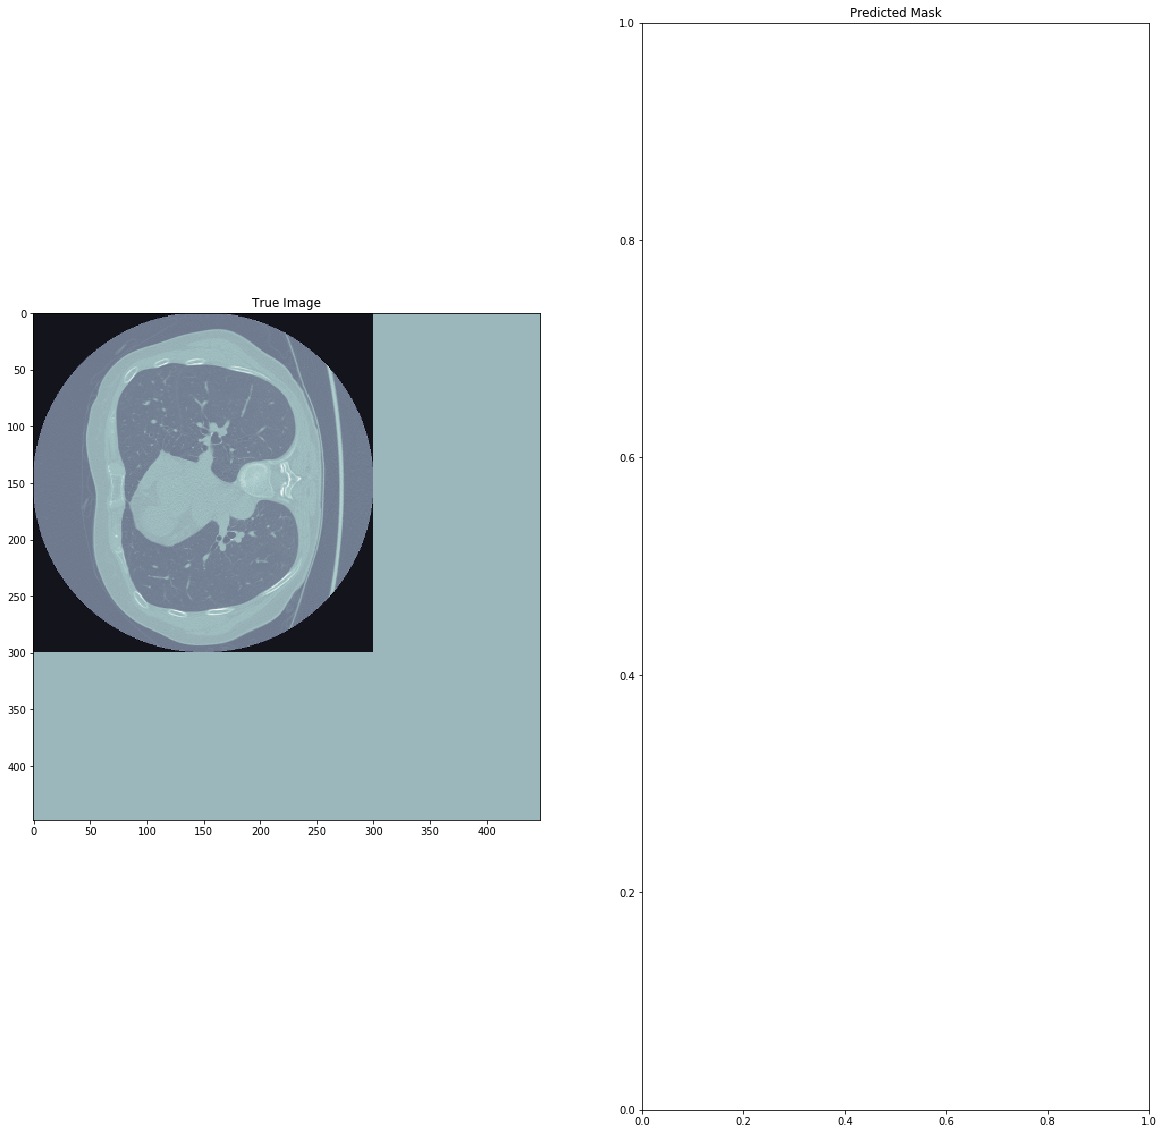

In [94]:
def displaySlice(sliceNo):
    
    plt.figure(figsize=[20,20]);    
    plt.subplot(121)
    plt.title("True Image")
    plt.imshow(img[:, :, sliceNo], cmap='bone');

    plt.subplot(122)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask[:, :, sliceNo], cmap='bone');
    plt.show()
interact(displaySlice, sliceNo=(1,img.shape[2],1));

###### Following sections for reference & WIP code snippets -AL

In [ ]:
## Multiple tile test....performance hog, so exploiting the GPU for entire slice without compromising predictions 
##and for better performance  -AL

# slices = 16
# predicted_img = np.zeros(padded_size)

# for i in range(368//slices):
#     tile_1 = padded_img[:224, :224, (i*slices) : slices*(i+1)]
#     tile_2 = padded_img[224:, 224:, (i*slices) : slices*(i+1) ] 

In [ ]:
# slices = 8
# predicted_mask = np.zeros(PADDED_SIZE)

# for i in range(24//SLICES):
#     tile = padded_img[:, :, (i*SLICES) : SLICES*(i+1)]
#     tile = tile.reshape(tuple([1] + list (tile.shape) + [1]))
# #     print(tile.shape)

#     tile_predictions = model.predict(tile, verbose=2)
#     tile_mask = tile_predictions[0].reshape(448, 448, 8)
    
#     print (tile_mask.shape)
#     predicted_mask[:, :, (i*SLICES) : SLICES*(i+1)] = tile_mask


In [ ]:
# slices = 8
# test_slice = padded_img[:, :, :slices]
# print(test_slice.shape)
# model = model_create_loadWghts(test_slice.shape) 
# # slice_predictions = model.predict(test_slice, verbose=2)

In [ ]:
# print ("Shape of predicted mask or segmented image : {}".format(predictions_small_img[0].shape))
# print ("Shape of predicted class : {}".format(predictions_small_img[1].shape))
# predictions_small_img[0] [:, 25 : 26, :]

In [ ]:
# ## AL - TEST : making an image of size 48,48,48 with random 0 or 1
# ### Case 2 : As a test created an input image of size (1, 48,48,48,1) 
# # with random 0 or 1; this works fine and able to create predictions successfully
# t2 =  np.random.choice(2,(48,48,48))
# t2 = t2.reshape(tuple([1] + list (t2.shape) + [1]))

# print ("Shape of test input image : {}".format(t2.shape))
# predictions = model.predict(t2, verbose=2)

# print ("Shape of predicted mask or segmented image : {}".format(predictions[0].shape))
# print ("Shape of predicted class : {}".format(predictions[1].shape))
# # predictions[0] [:, 25 : 26, :]

In [ ]:
# padded_img[225:232, 225:232, 175]
# predicted_mask[225:232, 225:232, 175]